# V1 graph database queries

This notebook shows the kinds of queries we'll need to do to pull out text co-assignment graphs from the v1 data. The mechanics of this will change a bit for the v2 data, though conceptually, it should be pretty much the same.

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline

In [58]:
import pandas as pd
import networkx as nx

from collections import Counter
from itertools import combinations

from sqlalchemy.sql import functions as func
from sqlalchemy.dialects.postgresql import array_agg

from osp_graphs.v1_db import session, Text, Field, Subfield, SubfieldDocument, Citation, Document

First, a function that takes the name of one of the top-level "fields" in the database and returns the ids for the N texts in that field that are assigned most frequently in the syllabus corpus. Basically, the query just:

- Selects the `Text.id` column.
- Joins on the sequence of tables that connect text IDs to field records - the `.join(Citation, Document, ...)` call. 
- Just takes texts that are marked as `valid` - they haven't been blacklisted because they have very common words in both the title and author fields, making them hard to reliably identify.
- And, just take texts that are marked as `display`, which means that, if there are multiple versions / editions of the text, we've chosen this one as the "representative" version.
- Group by `Text.id`, so that we don't get duplicate texts.
- Order by the number of times each text appears in the citation table.
- Just skim off the N most frequent texts.

In [59]:
def top_texts_by_field(field, n=20):

    count = func.count(Citation.text_id)

    res = (session
        .query(Text.id)
        .join(Citation, Document, SubfieldDocument, Subfield, Field)
        .filter(Text.valid==True)
        .filter(Text.display==True)
        .filter(Field.name==field)
        .group_by(Text.id)
        .order_by(count.desc())
        .limit(n))
    
    return set([r[0] for r in res.all()])

Now, we can just pass the name of a field, and get a set of ids. Eg, the 20 most-assigned books in philosophy:

In [60]:
text_ids = top_texts_by_field('Philosophy', 20)

In [61]:
text_ids

{11323,
 16073,
 252855,
 957631,
 984414,
 1093267,
 1137802,
 1140156,
 1202636,
 1453385,
 1601490,
 1711005,
 1801179,
 1823516,
 1906154,
 2065426,
 2200317,
 3247487,
 3606677,
 5655902}

Next, we can create an empty graph instance:

In [28]:
graph = nx.Graph()

To build out the edges between the texts in the graph, we need to get the number of times that each pair of texts appears on the same syllabus. Eg, if the set of the top 20 texts includes *The Republic* and *On Liberty*, we want to know exactly how many syllabi those two books appeared on together, so we can weight the connection with that number. There are a couple ways we could structure this query, but one pretty easy way is to use Postgres's `array_agg` function to group the text ids by the `id` of the syllabus:

In [48]:
doc_texts = (session
    .query(array_agg(Citation.text_id))
    .join(Text, Citation.text_id==Text.id)
    .filter(Text.valid==True)
    .filter(Text.display==True)
    .filter(Text.id.in_(text_ids))
    .group_by(Citation.document_id))

Since we're only considering the top 20 texts, in a lot of cases there will be only one of those texts on a syllabus. But, we care about the ones where there are 2+, of which there are 3 in the first 10 results:

In [49]:
doc_texts.all()[:10]

[([1711005]),
 ([3606677]),
 ([984414]),
 ([1202636]),
 ([1453385]),
 ([957631, 5655902, 2200317]),
 ([1711005]),
 ([252855, 1137802, 5655902]),
 ([1202636, 252855, 1711005, 984414]),
 ([2200317])]

We can then loop through this list of text id lists, take all unique pairs of the ids in each document, and build up a counter dictionary that keeps track of how many times each `(text A, text B)` pair appears together on a syllabus.

In [50]:
edges = Counter()
for ids in doc_texts:
    for tid1, tid2 in combinations(sorted(ids[0]), 2):
        edges[tid1, tid2] += 1

Then, we just register the edges in the graph:

In [51]:
for (tid1, tid2), count in edges.items():
    graph.add_edge(tid1, tid2, weight=count)

Next, we load the complete metadata rows for each text from the `Text` table:

In [52]:
texts = session.query(Text).filter(Text.id.in_(text_ids))

And set the `title` key on each node in the graph, which makes it possible to label the nodes:

In [53]:
for text in texts:
    graph.add_node(text.id, title=text.title)

Now, the graph is fully constructed, and we can lay it out with the built-in `draw_spring` method in NetworkX, which is kind of ugly... But, useful as a first test.

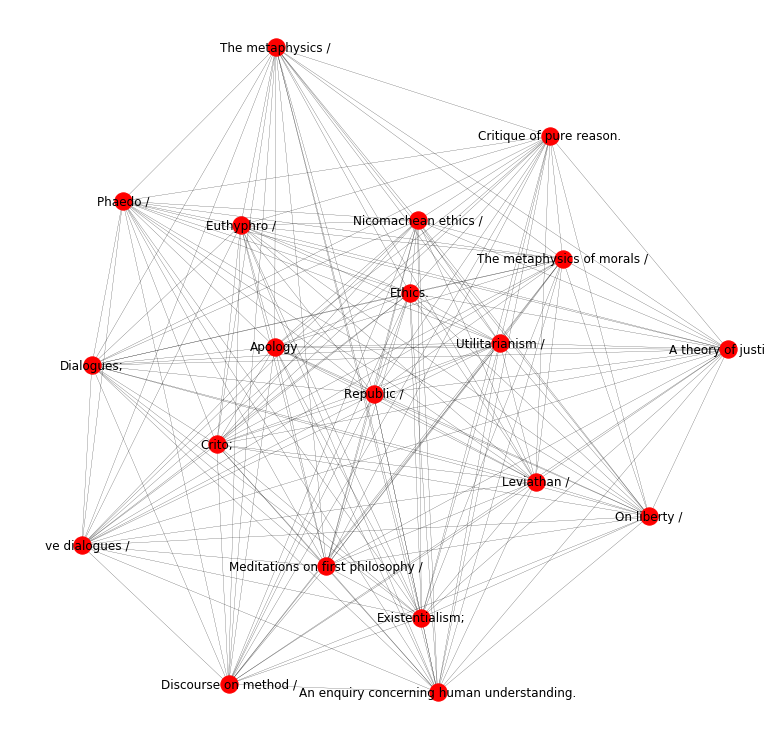

In [55]:
labels = nx.get_node_attributes(graph, 'title')
plt.figure(figsize=(10,10))
nx.draw_spring(graph, width=0.2, labels=labels)

We can also dump the graph as a .graphml (or .gml, or .gexf) file, which can be imported into Gephi.

In [56]:
nx.write_graphml(g, 'test.graphml')